#调用GPU

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#下载pytorch

In [ ]:
!pip3 install torch torchvision torchaudio

In [ ]:
!pip3 install d2l==0.14

#下载数据集

In [ ]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

     |████████████████████████████████| 58 kB 3.1 MB/s             
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72858 sha256=5749773082a14909ed85e25bf3d13dfde1d682ac40abca3e0f2c2008b0c2b1a8
  Stored in directory: /root/.cache/pip/wheels/aa/e7/e7/eb3c3d514c33294d77ddd5a856bdd58dc9c1fabbed59a02a2b
Successfully built kaggle


In [ ]:
!cd /root && mkdir -p ./.kaggle && mv /root/kaggle.json /root/.kaggle/

In [ ]:
!cd /root/.kaggle && ls

kaggle.json


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dog-breed-identification -p /data

 98% 679M/691M [00:06<00:00, 125MB/s]
100% 691M/691M [00:06<00:00, 117MB/s]


In [ ]:
!unzip /data/dog-breed-identification.zip -d /data/dog-breed-identification

Streaming output truncated to the last 5000 lines.
  inflating: /data/dog-breed-identification/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: /data/dog-breed-identification/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: /data/dog-breed-identification/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: /data/dog-breed-identification/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: /data/dog-breed-identification/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: /data/dog-breed-identification/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: /data/dog-breed-identification/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: /data/dog-breed-identification/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: /data/dog-breed-identification/train/83fad0718581a696132c96c166472627.jpg  
  inflating: /data/dog-breed-identification/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: /data/dog-breed-identification/train/8403d8936

#狗的品种识别

In [ ]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

##读取数据路径

In [ ]:
d2l.DATA_HUB['dog_tiny'] = (d2l.DATA_URL + 'kaggle_dog_tiny.zip','0cb91d09b814ecdc07b50f31f8dcad3e81d6a86d')

demo = False
if demo:
    data_dir = d2l.download_extract('dog_tiny')
else:
    data_dir = os.path.join('..','data','dog-breed-identification')

In [ ]:
#读取.csv类型的标签文件
def read_csv_labels(fname):
    with open(fname,'r') as f:
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name,label) for name,label in tokens))

#复制文件
def copyfile(filename,target_dir):
    os.makedirs(target_dir,exist_ok=True)
    shutil.copy(filename,target_dir)

#划分开发集
def reorg_train_valid(data_dir,labels,valid_ratio):
    #训练数据集中样本数量最少的类别中的样本数
    n = collections.Counter(labels.values()).most_common()[-1][1]
    #开发集中每个类别的样本数
    n_valid_per_label = max(1, math.floor(n*valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir,'train')):
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir,'train',train_file)
        copyfile(fname,os.path.join(data_dir,'train_valid_test','train_valid',label))
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(fname,os.path.join(data_dir,'train_valid_test','valid',label))
            label_count[label] = label_count.get(label,0)+1
        else:
            copyfile(fname,os.path.join(data_dir,'train_valid_test','train',label))
    return n_valid_per_label

def reorg_test(data_dir):
    #重整测试集
    for test_file in os.listdir(os.path.join(data_dir,'test')):
        copyfile(os.path.join(data_dir,'test',test_file),os.path.join(data_dir,'train_valid_test','test','unknown'))

In [ ]:
#重整数据
def reorg_dog_data(data_dir,valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir,'labels.csv'))
    reorg_train_valid(data_dir,labels,valid_ratio)
    reorg_test(data_dir)

#制定超参数
#完整数据集batch_size为128
batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_dog_data(data_dir,valid_ratio)

In [ ]:
#图像增广
transform_train = torchvision.transforms.Compose([
                                                  #随机剪裁图像，所得图像为原始面积的0.08到1之间，高宽比在3/4和4/3之间
                                                  #然后，缩放图像以创建224x224的新图像
                                                  torchvision.transforms.RandomResizedCrop(224,scale=(0.08,1.0),
                                                                                           ratio=(3.0/4.0,4.0/3.0)),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  #随机更改亮度，对比度和饱和度
                                                  torchvision.transforms.ColorJitter(brightness=0.4,
                                                                                     contrast=0.4,
                                                                                     saturation=0.4),
                                                  #添加随机噪声
                                                  torchvision.transforms.ToTensor(),
                                                  #标准化图像的每个通道
                                                  torchvision.transforms.Normalize([0.485,0.456,0.406],
                                                                                   [0.229,0.224,0.225])])
transform_test = torchvision.transforms.Compose([
                                                  torchvision.transforms.Resize(256),
                                                  #从图像中心裁切224x224大小的图片
                                                  torchvision.transforms.CenterCrop(224),
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize([0.485,0.456,0.406],
                                                                                   [0.229,0.224,0.225])])

In [ ]:
#读取训练集、开发集和测试集
train_ds,train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir,'train_valid_test',folder),
    transform=transform_train) for folder in ['train','train_valid']]

valid_ds,test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir,'train_valid_test',folder),
    transform=transform_test) for folder in ['valid','test']]

In [ ]:
train_iter,train_valid_iter = [torch.utils.data.DataLoader(
    dataset,batch_size,shuffle=True,drop_last=True) for dataset in (train_ds,train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds,batch_size,shuffle=False,drop_last=True)
test_iter = torch.utils.data.DataLoader(test_ds,batch_size,shuffle=False,drop_last=False)

In [ ]:
#搭建微调预训练模型
def get_net(devices):
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet34(pretrained=True)
    #定义一个新的输出网络，共有120个输出类别
    finetune_net.output_new = nn.Sequential(nn.Linear(1000,256),
                                            nn.ReLU(),
                                            nn.Linear(256,120))
    #将模型参数分配给用于计算的CPU或GPU
    finetune_net = finetune_net.to(devices[0])
    #冻结参数
    for param in finetune_net.features.parameters():
        param.requires_grad = False
    return finetune_net

In [ ]:
loss = nn.CrossEntropyLoss(reduction='none')

def evaluate_loss(data_iter,net,devices):
    l_sum,n = 0.0,0
    for features,labels in data_iter:
        features,labels = features.to(devices[0]),labels.to(devices[0])
        outputs = net(features)
        l = loss(outputs,labels)
        l_sum += l.sum()
        n += labels.numel()
    return (l_sum / n).to('cpu')

In [ ]:
def train(net,train_iter,valid_iter,num_epochs,lr,wd,devices,lr_period,lr_decay):
    net = nn.DataParallel(net,device_ids=devices).to(devices[0])
    trainer = torch.optim.SGD((param for param in net.parameters() if param.requires_grad),lr=lr,momentum=0.9,weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer,lr_period,lr_decay)
    num_batches,timer = len(train_iter),d2l.Timer()
    legend = ['train_loss']
    if valid_iter is not None:
        legend.append('valid loss')
    animator = d2l.Animator(xlabel='epoch',xlim=[1,num_epochs],legend=legend)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        for i,(features,labels) in enumerate(train_iter):
            timer.start()
            features, labels = features.to(devices[0]),labels.to(devices[0])
            trainer.zero_grad()
            output = net(features)
            l = loss(output,labels).sum()
            l.backward()
            trainer.step()
            metric.add(l,labels.shape[0])
            timer.stop()
            if (i+1)%(num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i+1) / num_batches,(metric[0] / metric[1],None))
        measures = f'train loss {metric[0] / metric[1]:.3f}'
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter,net,devices)
            animator.add(epoch+1,(None,valid_loss.detach()))
        scheduler.step()
    if valid_iter is not None:
        measures += f',valid loss {valid_loss:.3f}'
    print(measures + f'\n{metric[1] * num_epochs / timer.sum():.1f}' f' examples/sec on {str(devices)}')

train loss 0.973,valid loss 0.730
349.3 examples/sec on [device(type='cuda', index=0)]


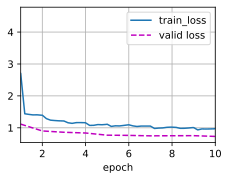

In [ ]:
devices,num_epochs,lr,wd = d2l.try_all_gpus(),10,1e-4,1e-4
lr_period,lr_decay,net = 2,0.9,get_net(devices)
train(net,train_iter,valid_iter,num_epochs,lr,wd,devices,lr_period,lr_decay)

train loss 0.987
348.7 examples/sec on [device(type='cuda', index=0)]


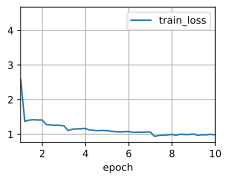

In [ ]:
net = get_net(devices)
train(net,train_valid_iter,None,num_epochs,lr,wd,devices,lr_period,lr_decay)

preds = []
for data,label in test_iter:
    output = torch.nn.functional.softmax(net(data.to(devices[0])),dim=0)
    preds.extend(output.cpu().detach().numpy())
ids = sorted(os.listdir(os.path.join(data_dir,'train_valid_test','test','unknown')))
with open('submission.csv','w') as f:
    f.write('id,'+','.join(train_valid_ds.classes)+'\n')
    for i,output in zip(ids,preds):
        f.write(i.split('.')[0] + ',' + ','.join([str(num) for num in output]) + '\n')